# Efficient Portfolios
###### Petko Vladimirov Stoyanov - 21208084 - UCD Michael Smurfit Business School

## Exercise 1 - 40 marks
Analyse two models for the input of historical data.

### Model 1
Download weekly price of the stock indices [27-Jan-2020, 23-Mar-2020] (9 prices, 8 returns):

   - US: Dow Jones Industrial `^DJI`, S&P500 `^GSPC`
   - UK: FTSE100 `^FTSE`
   - Europe: MSCI Eurozone `EZU`
   - Gold `GLD`

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import scipy.optimize as sco

warnings.filterwarnings('ignore')

For this point we are using the yfinance package in order to download weekly price data for the stocks listed.
We will download all the data for the given tickers from the start to the end date (in this case we used 24th of March instead of 23rd because the api excludes the last week if it is at the start). From that data we are only using the Adjusted Closing price.

In [2]:

ticker_list = ['^DJI', '^GSPC', '^FTSE', 'EZU', 'GLD']
model1 = yf.download(ticker_list, start="2020-01-27", end="2020-03-24", interval="1wk")['Adj Close']
model1

[*********************100%***********************]  5 of 5 completed


,EZU,GLD,^DJI,^FTSE,^GSPC
Date,,,,,
2020-01-27,38.602440,149.330002,28256.029297,7286.000000,3225.520020
2020-02-03,39.699097,147.789993,29102.509766,7466.700195,3327.709961
2020-02-10,39.994717,149.000000,29398.080078,7409.100098,3380.159912
2020-02-17,39.584663,154.699997,28992.410156,7403.899902,3337.750000
2020-02-24,35.751122,148.380005,25409.359375,6580.600098,2954.219971
2020-03-02,35.293381,157.550003,25864.779297,6462.600098,2972.370117
2020-03-09,29.018581,143.279999,23185.619141,5366.100098,2711.020020
2020-03-16,25.261328,140.110001,19173.980469,5190.799805,2304.919922
2020-03-23,25.547415,146.300003,18591.929688,4993.899902,2237.399902


We obtained 9 price observations, which will be transformed into 8 log returns further when manipulating the data.

### Model 2
Download weekly price of the stock indices [Jan-2015, Dec-2019]:

   - US: Dow Jones Industrial `^DJI`, S&P500 `^GSPC`
   - UK: FTSE100 `^FTSE`
   - Europe: MSCI Eurozone `EZU`
   - Gold `GLD`

In [3]:
model2 = yf.download(ticker_list, start="2015-01-01", end="2019-12-31", interval="1wk")['Adj Close']
model2.dropna(inplace=True)
model2

[*********************100%***********************]  5 of 5 completed


,EZU,GLD,^DJI,^FTSE,^GSPC
Date,,,,,
2014-12-29,30.436682,114.080002,17832.990234,6547.799805,2058.199951
2015-01-05,29.382238,117.260002,17737.369141,6501.100098,2044.810059
2015-01-12,30.177261,122.519997,17511.570312,6550.299805,2019.420044
2015-01-19,30.587320,124.230003,17672.599609,6832.799805,2051.820068
2015-01-26,30.696115,123.449997,17164.949219,6749.399902,1994.989990
...,...,...,...,...,...
2019-12-02,38.843266,137.619995,28015.060547,7239.700195,3145.909912
2019-12-09,39.432083,139.050003,28135.380859,7353.399902,3168.800049
2019-12-16,39.527058,139.520004,28455.089844,7582.500000,3221.219971


For the second model, we obtained a total of 262 price observations for 5 years of stock data.

### Calculate expected annual returns and covariance matrix.

In order to calculate the returns of a certain stock we will use the adjusted close price of each period.
Annual (total) returns: $R_a = \frac{R_n - R_0}{R_0}$

In [4]:
# calculates the annualised return of a given time series
def annual_return(time_series):
    return (time_series[-1] - time_series[0]) / time_series[0]


# obtains the log returns of the given time series
def get_log_return(time_series):
    return np.log(1 + time_series.pct_change())


# clears model for better indexing, visualization and manipulation
def clear_model(model):
    model_clear = model
    if type(model.index) is not pd.MultiIndex:
        model_clear.index = pd.MultiIndex.from_tuples(zip(model.index.year, model.index), names=['Year', 'Date'])
    return model_clear


def get_returns(model):
    returns = model.groupby('Year').count()
    for ticker in model:
        for year in returns.index:
            returns.loc[year, ticker] = annual_return(model.loc[year, ticker])
    return returns


def get_returns_adjusted(model):
    '''
    Returns two dataframes with the annual returns and the mean of log returns
        adjusted for the last period price when available
    '''
    returns = model.groupby('Year').count()
    log_returns = model.groupby('Year').count()
    for ticker in model:
        for year in returns.index:
            if year - 1 in returns.index:
                prev_close = model.loc[year - 1, ticker].iloc[-1:]
                annual_series = prev_close.iloc[-1:].append(model.loc[year, ticker])
                returns.loc[year, ticker] = annual_return(annual_series)
                log_returns.loc[year, ticker] = get_log_return(annual_series).mean()
            else:
                returns.loc[year, ticker] = annual_return(model.loc[year, ticker])
                log_returns.loc[year, ticker] = get_log_return(model.loc[year, ticker]).mean()

    return returns, log_returns

Annual Returns and Expected annual returns:

In [5]:
models = {'model 1': model1, 'model 2': model2}  # dictionary that contains all the data of each model
expected_returns_dict = {'model 1': None, 'model 2': None}  # dictionary to store the expected returns for each model

for model in models:
    print(model, 'Annual returns:')
    model_clear = clear_model(models[model])
    model_returns, model_log_returns = get_returns_adjusted(model_clear)
    display(model_returns)
    print(model, 'Expected annual returns (mean of log returns):')
    expected_return = model_log_returns.mean().dropna()
    expected_returns_dict[model] = expected_return
    display(expected_return)

model 1 Annual returns:


,EZU,GLD,^DJI,^FTSE,^GSPC
Year,,,,,
2020,-0.338192,-0.020291,-0.342019,-0.31459,-0.306344


model 1 Expected annual returns (mean of log returns):


EZU     -0.051597
GLD     -0.002562
^DJI    -0.052322
^FTSE   -0.047217
^GSPC   -0.045722
dtype: float64

model 2 Annual returns:


,EZU,GLD,^DJI,^FTSE,^GSPC
Year,,,,,
2014,0.000000,0.000000,0.000000,0.000000,0.000000
2015,-0.017495,-0.110624,-0.022877,-0.046657,-0.006928
2016,0.018633,0.080327,0.134150,0.144258,0.095350
2017,0.278902,0.128091,0.250808,0.076301,0.194200
2018,-0.155695,-0.017873,-0.052027,-0.110617,-0.052988
2019,0.209282,0.174489,0.214610,0.109647,0.272262


model 2 Expected annual returns (mean of log returns):


EZU      0.001042
GLD      0.000860
^DJI     0.001802
^FTSE    0.000575
^GSPC    0.001727
dtype: float64

In the upper tables we can see the annualised returns for each model:

1. For the first one we only have the year 2020, as our data for that model only comprises 3 the first three months of that year. We can notice that all the returns are negative, given the scenario and context that took place during that time period, this is completely expected. We have a period of recess, and the stock prices reflect that.

2. For our second model, we have the data of the 5 years required (it shows also the year 2014, because the first week of 2015 includes a data point from the previous year, but this does not affect the results nor the analysis). We have plenty of annualised returns, some of them positive, some of them negative, reflecting the nature of the stock market.

The expected annual returns for the models, are given by the mean of the log returns for each stock, from this data we will build the covariances matrices and the optimal portfolios in each case.

Covariance matrix is calculated on the log returns matrix:

In [6]:
covariances = {'model 1': None, 'model 2': None}

for model in models:
    log_returns = get_log_return(models[model]).dropna()
    matrix = log_returns.cov()
    print(model, 'Covariance matrix:')
    display(matrix)
    covariances[model] = log_returns.cov()

model 1 Covariance matrix:


,EZU,GLD,^DJI,^FTSE,^GSPC
EZU,0.006838,0.003425,0.005722,0.004851,0.004969
GLD,0.003425,0.002607,0.002578,0.002749,0.002134
^DJI,0.005722,0.002578,0.006569,0.003422,0.005734
^FTSE,0.004851,0.002749,0.003422,0.004888,0.003044
^GSPC,0.004969,0.002134,0.005734,0.003044,0.005040


model 2 Covariance matrix:


,EZU,GLD,^DJI,^FTSE,^GSPC
EZU,0.000468,-0.000033,0.000276,0.000248,0.000281
GLD,-0.000033,0.000299,-0.000056,-0.000040,-0.000048
^DJI,0.000276,-0.000056,0.000334,0.000215,0.000315
^FTSE,0.000248,-0.000040,0.000215,0.000318,0.000220
^GSPC,0.000281,-0.000048,0.000315,0.000220,0.000320


### Optimal portfolio in each case

In order to calculate the optimal portfolio, there are different approaches, but we are going to follow the min-variance portfolio, while visualizing the efficient frontier for the different options

$$ E_{ret} = w_1·\sigma_1 + w_2·\sigma_2$$

$$ P_{var} = w_1^2·\sigma_1^2 + w_2^2·\sigma_2^2 + 2·w_1·w_2·Cov_{1,2}$$

Upper formula is calculated for a portfolio with 2 assets, but applying algebraic functions we can extend it to a larger portfolio.

We will also make use of the Risk Free rate defined by Fama and French to apply to the 3 Factor Model bafore calculating the optimal portfolios. [Source: [Weekly Fama/French 3 Factors](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)]


In [7]:
fff = pd.read_csv('F-F_Research_Data_Factors_weekly.csv', skiprows=3,
                  skipfooter=1)  # load the fama and french 3 factors weekly data from the csv
fff['Date'] = pd.to_datetime(fff.iloc[:, 0], format='%Y%m%d')  # change format of the date in the csv
rf = fff[['Date', 'RF']]  # select the risk free rate
model1_rf = rf[(rf['Date'] >= '2020-01-27') & (rf['Date'] <= '2020-03-23')]
print(f'Model 1 RF (mean value): {round(model1_rf.mean()[0], 3)}')
model2_rf = rf[(rf['Date'] >= '2015-01-01') & (rf['Date'] <= '2019-12-31')]
print(f'Model 2 RF (mean value): {round(model2_rf.mean()[0], 3)}')
# save the Rf rates of each model filtered correctly by date
risk_free_rates = {'model 1': model1_rf, 'model 2': model2_rf}

Model 1 RF (mean value): 0.031
Model 2 RF (mean value): 0.02


To estimate the optimal portfolio in each case, we can either follow a random approach, generating a large number of portfolios, or directly minimizing the function.
In both cases we will calculate the minimum variance portfolio, and the maximum sharpe ratio portfolio.

$$ S = \frac{R_p-R_f}{\sigma_p} $$

The sharpe ratio (upper formula) is and indicator of the return (expected) per unit of risk (volatility). By maximising this ratio, we will obtain the optimal portfolio in terms of returns and volatility.

`1. The first approach we will use is: Generating 100000 random portfolios with different weights: This will allow us to visualize the efficient frontier, and select the portfolios that either have the minimum variance, or the maximum sharpe ratio.`

In [8]:
# expected returns function given a mean return matrix and weights
def expected_return(mean_returns, weight):
    return np.dot(mean_returns, weight) * 52


# random weight generator
def rand_weigh(size_r):
    rnd = np.random.random(size_r)
    rnd /= rnd.sum()  # weights need to add up to 1
    return rnd


# portfolio variance function given a weights array, a covariance matrix and a number of periods
def portfolio_var(weights_p, cov_matrix, periods):
    return np.sqrt(np.dot(weights_p.T, np.dot(cov_matrix * periods, weights_p)))

model 1 (Rf: 0.031):
---------------MIN-VARIANCE----------------
Variance:0.3685	Return:-0.6149	Sharpe:-1.6696563242485354
Weights:[0.0164 0.7903 0.0099 0.0326 0.1509]
---------------MAX SHARPE RATIO----------------
Variance:0.3719	Return:-0.4064	Sharpe:-1.0935809521785635
Weights:[0.0175 0.8874 0.0324 0.0504 0.0122]


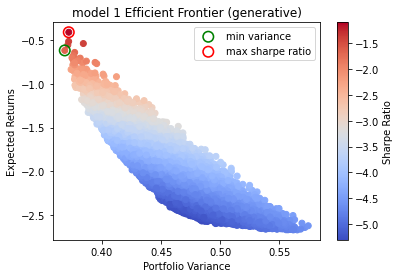

model 2 (Rf: 0.02):
---------------MIN-VARIANCE----------------
Variance:0.0784	Return:0.0538	Sharpe:0.6836659808975435
Weights:[0.0006 0.4818 0.1916 0.2508 0.0752]
---------------MAX SHARPE RATIO----------------
Variance:0.0869	Return:0.0745	Sharpe:0.8549103930504142
Weights:[0.0039 0.3641 0.3635 0.0035 0.265 ]


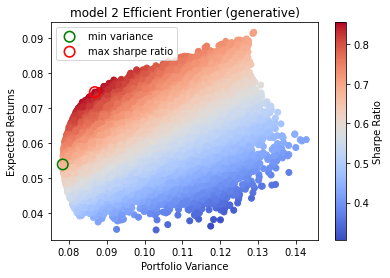

In [9]:
gen_port = {}  # dict to store the generated random portfolios data
optimal_portfolios_gen = {}  # dict to store the optimal portfolios generated


# function to generate a number of random portfolios given a covariance matrix and the expected returns and risk free rate
def generate_portfolios(number_portfolios, covariance_matrix, expected_returns, risk_rate):
    returns_p = []
    variances_p = []
    weights_p = []
    sharpe_ratios_p = []
    for i in range(number_portfolios):
        w = rand_weigh(len(covariance_matrix))
        weights_p.append(w)
        e = expected_return(expected_returns, w)
        returns_p.append(e)
        v = portfolio_var(w, covariance_matrix, 52)  # 52 weeks annually
        variances_p.append(v)
        sharpe_ratios_p.append((e - risk_rate / 100) / v)
    return returns_p, variances_p, weights_p, sharpe_ratios_p


for model in models:
    covariance = covariances[model]
    rfr = risk_free_rates[model].mean()[0]
    print(f'{model} (Rf: {round(rfr, 3)}):')
    rfr = np.log(1 + rfr)  # for calculations we are using the log, like we did with the returns
    returns, variances, weights, sharpe_ratios = generate_portfolios(100000, covariance, expected_returns_dict[model],
                                                                     rfr)  # generate 100_000 random portfolios
    plt.scatter(variances, returns, c=sharpe_ratios,
                cmap='coolwarm')  # plot all the portfolios of the model (variance/returns)
    plt.colorbar(label='Sharpe Ratio')
    min_v = min(variances)
    index = variances.index(min_v)
    min_ret = returns[index]
    min_w = weights[index]
    # display optimal portfolios and plots of the data
    print('---------------MIN-VARIANCE----------------')
    print(
        f'Variance:{round(min_v, 4)}\tReturn:{round(min_ret, 4)}\tSharpe:{sharpe_ratios[index]}\nWeights:{np.around(min_w, 4)}')
    s = max(sharpe_ratios)
    s_index = sharpe_ratios.index(s)
    print('---------------MAX SHARPE RATIO----------------')
    print(
        f'Variance:{round(variances[s_index], 4)}\tReturn:{round(returns[s_index], 4)}\tSharpe:{sharpe_ratios[s_index]}\nWeights:{np.around(weights[s_index], 4)}')
    plt.scatter(min_v, min_ret, facecolors='none', edgecolors='green', s=110, linewidth=1.6, label='min variance')
    plt.xlabel('Portfolio Variance')
    plt.ylabel('Expected Returns')
    plt.title(f'{model} Efficient Frontier (generative)')
    plt.scatter(variances[s_index], returns[s_index], facecolors='none', edgecolors='red', s=110, linewidth=1.6,
                label='max sharpe ratio')
    # plt.scatter(0,rfr,c='g',label='RF rate')  # risk free rate is far off so visualization is not proper
    plt.legend()
    plt.show()
    gen_port[model] = pd.DataFrame({'ret': returns, 'vol': variances, 'sr': sharpe_ratios})  # store data generated data
    optimal_portfolios_gen[model] = {'min_v': {'volatility': min_v, 'return': min_ret, 'weights': min_w},
                                     'max_sr': {'volatility': variances[s_index], 'return': returns[s_index],
                                                'weights': weights[s_index]}}


As we have generated 100.000 different portfolios, we can now visualize the efficient frontier of each model.

From the upper plots and data, we can distinguish the optimal portfolios in terms of variance and sharpe ratio, within all of the generated data.
This approach is not exact, as it is based on randomness it will always give us a different results, but it will serve its purpose to compare to future calculations.

        2. Apply optimization to maximize the Sharpe Ratio or minimize the variance separately



model 1 (Rf: 0.0306):
**********Min-Variance**********
Variance:0.3635	Return:-0.4477
Weights: [0.     0.8599 0.     0.     0.1401]
Sharpe Ratio:-1.1475499614906115

**********Sharpe Ratio**********
Variance:0.3682	Return:-0.1332
Weights: [0. 1. 0. 0. 0.]
Sharpe Ratio:-0.27870775835675166



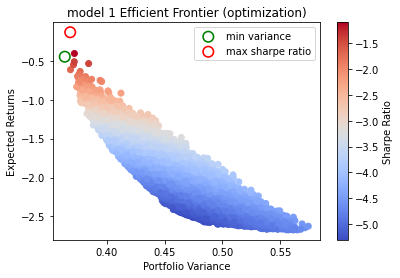


model 2 (Rf: 0.0205):
**********Min-Variance**********
Variance:0.0783	Return:0.0546
Weights: [0.     0.479  0.2726 0.245  0.0035]
Sharpe Ratio:0.958421038627547

**********Sharpe Ratio**********
Variance:0.0842	Return:0.0726
Weights: [0.     0.4249 0.502  0.     0.073 ]
Sharpe Ratio:1.1058642414461828



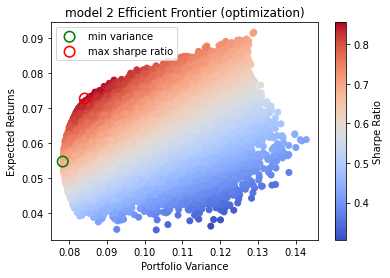

In [10]:
def calculate_sharpe(weights_s, returns_s, covariance_s, periods, rf_s):
    return (-expected_return(returns_s, weights_s) - rf_s) / portfolio_var(weights_s, covariance_s, periods)


def minimize_var(log_returns_matrix, covariance_matrix, rf_matrix, n_periods, weights_arr, bounds, contraints):
    optv = sco.minimize(portfolio_var, weights_arr, args=(covariance_matrix, n_periods), method='SLSQP', bounds=bounds,
                        constraints=contraints)  # variance optimization
    w_v = optv['x']  # weights of variance minimization
    var_v = portfolio_var(w_v, covariance_matrix, n_periods)
    ret_v = expected_return(log_returns_matrix, w_v)
    sr_v = -calculate_sharpe(w_v, log_returns_matrix, covariance_matrix, n_periods, rf_matrix)
    print('**********Min-Variance**********')
    print(f'Variance:{round(var_v, 4)}\tReturn:{round(ret_v, 4)}\nWeights: {np.around(w_v, 4)}')
    print(f'Sharpe Ratio:{sr_v}')
    return w_v, var_v, ret_v


def maximize_sharpe(log_returns_matrix, covariance_matrix, rf_matrix, n_periods, weights_arr, bounds, contraints):
    opts = sco.minimize(calculate_sharpe, weights_arr,
                        args=(log_returns_matrix, covariance_matrix, n_periods, rf_matrix), method='SLSQP',
                        bounds=bounds, constraints=contraints)  # sharpe optimization
    w_s = opts['x']  # weights of sharpe maximization
    var_s = portfolio_var(w_s, covariance_matrix, n_periods)
    ret_s = expected_return(ret, w_s)
    sr_s = -calculate_sharpe(w_s, ret, covariance_matrix, n_periods, rf_matrix)
    print('\n**********Sharpe Ratio**********')
    print(f'Variance:{round(var_s, 4)}\tReturn:{round(ret_s, 4)}\nWeights: {np.around(w_s, 4)}')
    print(f'Sharpe Ratio:{sr_s}\n')
    return w_s, var_s, ret_s


constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
size = len(ticker_list)
bound = tuple((0, 1) for x in range(size))
eq_weights = np.array(size * [1. / size, ])

for model in covariances:
    rf = risk_free_rates[model].mean()[0]
    cov = covariances[model]
    ret = expected_returns_dict[model]
    n = 52
    print(f'\n{model} (Rf: {round(rf, 4)}):')
    weights_minvar, vol_minvar, ret_minvar = minimize_var(ret, cov, rf, n, eq_weights, bound, constraint)
    weights_maxshr, vol_maxshr, ret_maxshr = maximize_sharpe(ret, cov, rf, n, eq_weights, bound, constraint)
    plt.scatter(gen_port[model].vol, gen_port[model].ret, c=gen_port[model].sr, cmap='coolwarm')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(vol_minvar, ret_minvar, facecolors='none', edgecolors='green', s=110, linewidth=1.6,
                label='min variance')
    plt.scatter(vol_maxshr, ret_maxshr, facecolors='none', edgecolors='red', s=110, linewidth=1.6,
                label='max sharpe ratio')
    plt.legend()
    plt.xlabel('Portfolio Variance')
    plt.ylabel('Expected Returns')
    plt.title(f'{model} Efficient Frontier (optimization)')
    plt.show()


Following this approach, and optimizing the portfolios in each case, we have obtained far better results in both cases.
With this calculations, we will always obtain the optimal portfolio in each case, wether it is by minimizing the variance, or maximizing the sharpe ratio, our results will be consistent.

### Which model is correct. Why?

We cannot say that one model or the other is correct or not. Instead of that we should be talking about which model is more accurate. In that case, it is obvious that the second model, that contains more data points is probably the most accurate.
The first model only depicts the starting period of a crisis, where all the stock prices were falling. Therefore we could say that the first model is biased, as it only contains a small amount of data in a particular period, which is not fair to the full model.
On the other hand, the second model contains data of 5 years, which gives us a bigger picture of the market, and more trustworthy. After all, with more data available to model, more precise will be the final result. In this model we find a variety of returns, and as we can see in the efficient frontier (Figure 2), it resembles more the expected (theoretical) efficient frontier of a portfolio.

As for the two approaches followed in this part, the second one, using optimization is definitely more accurate as it can either minimize the variance or maximize the sharpe ratio consistently. In contrast, the generative (first approach), may be more easily done/visualized, but it will never obtain the same results. For this matter, the second model gives us much better results, in fact, both minimum variance portfolio and maximum sharpe are practically the same.
Summing up, we have the following data to compare:



| Model     | Variance | &nbsp;        | Expected return | &nbsp;        | Sharpe Ratio | &nbsp;        |
|-----------|----------|---------------|-----------------|---------------|--------------|---------------|
| Portfolio | Min-var. | Max-Sharpe R. | Min-var.        | Max-Sharpe R. | Min-var.     | Max-Sharpe R. |
| 1 - Gen   | 0.3685   | 0.3719        | -0.6149         | -0.4064       | -1.6697      | -1.0935       |
| 1 - Opt   | 0.3635   | 0.3682        | -0.4477         | -0.1332       | -1.1475      | -0.2787       |
| 2 - Gen   | 0.0784   | 0.0869        | 0.0538          | 0.0745        | 0.6837       | 0.8549        |
| 2 - Opt   | 0.0783   | 0.0842        | 0.0546          | 0.0726        | 0.9584       | 1.1058        |

As we have all the results side-by-side, we can confirm our previous findings. Starting with the first model, the optimization one achieves a lower variance en both portfolios, as well as a higher expected return, and a significantly better sharpe ratio at the end. For the second model, we have the same results, but not as dramatical in comparison: lower variance, higher expected return and higher sharpe ratio in each portfolio.

## Exercise 2 - 60 Marks

Use shrinkage method to model the data

### Calculate annual covariance matrix with the estimated shrinkage

In [11]:
import numpy as np
import nonlinshrink as nls
from sklearn.covariance import LedoitWolf

We are going to use 2 packages to calculate the new covariance matrix for each model, applying the Ledoit-Wolf shrinkage method:
1. NonLinShrink
2. SkLearn.covariance LedoitWolf


In [12]:
model = 'model 1'
sh_returns = get_log_return(models[model]).dropna()
sigma_tilde = nls.shrink_cov(sh_returns)
sigma_tilde  # shrinkage covariance matrix

AssertionError: sample size n must be >= 12

<div class="alert alert-block alert-warning">
We cannot use the designated shrinkage method for model 1
<div>

In [13]:
model = 'model 2'
sh_returns = get_log_return(models[model]).dropna()
sigma_tilde = nls.shrink_cov(sh_returns)
sigma_tilde  # shrinkage covariance matrix

array([[ 4.70490904e-04, -3.27940718e-05,  2.77151718e-04,
         2.46703183e-04,  2.81662303e-04],
       [-3.27940718e-05,  3.00098567e-04, -5.62421336e-05,
        -3.99863384e-05, -4.81823542e-05],
       [ 2.77151718e-04, -5.62421336e-05,  3.35802673e-04,
         2.13621134e-04,  3.16352629e-04],
       [ 2.46703183e-04, -3.99863384e-05,  2.13621134e-04,
         3.24140269e-04,  2.18983747e-04],
       [ 2.81662303e-04, -4.81823542e-05,  3.16352629e-04,
         2.18983747e-04,  3.21153593e-04]])

In [14]:
# Using SKLearn.covariance LedoitWolf
sh_covariances = {}

for model in models:
    sh_returns = get_log_return(models[model]).dropna()
    sh_covariances[model] = LedoitWolf().fit(sh_returns).covariance_
    print(model)
    display(pd.DataFrame(sh_covariances[model]))


model 1


,0,1,2,3,4
0,0.005712,0.002434,0.004066,0.003446,0.003531
1,0.002434,0.002706,0.001832,0.001953,0.001516
2,0.004066,0.001832,0.005521,0.002431,0.004074
3,0.003446,0.001953,0.002431,0.004326,0.002163
4,0.003531,0.001516,0.004074,0.002163,0.004434


model 2


,0,1,2,3,4
0,0.000462,-0.000031,0.000266,0.000239,0.000270
1,-0.000031,0.000300,-0.000054,-0.000039,-0.000046
2,0.000266,-0.000054,0.000334,0.000207,0.000304
3,0.000239,-0.000039,0.000207,0.000317,0.000212
4,0.000270,-0.000046,0.000304,0.000212,0.000320


If we compare the upper covariances matrices, with the shrinkage applied, to the initial covariance matrices, we can infer:
 - For model 1, each one of the variance and covariance values is lower on the shrinkage matrix.
 - For model 2, we have mixed results, but the values only defer by a very low percentage, for both matrices the are very similar.

### Calculate optimal portfolio in both cases

We are going to use directly the optimization method applied previously to each one of the models


model 1 (Rf: 0.0306):
**********Min-Variance**********
Variance:0.347	Return:-0.9827
Weights: [0.     0.626  0.     0.1306 0.2433]
Sharpe Ratio:-2.743694181146947

**********Sharpe Ratio**********
Variance:0.3751	Return:-0.1332
Weights: [0. 1. 0. 0. 0.]
Sharpe Ratio:-0.2735816141320689



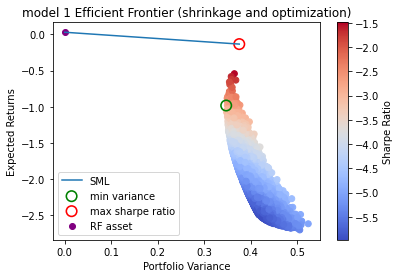


model 2 (Rf: 0.0205):
**********Min-Variance**********
Variance:0.0782	Return:0.055
Weights: [0.     0.4734 0.207  0.2387 0.0809]
Sharpe Ratio:0.9649091864534269

**********Sharpe Ratio**********
Variance:0.0839	Return:0.0725
Weights: [0.     0.4175 0.3987 0.     0.1837]
Sharpe Ratio:1.1080274056189219



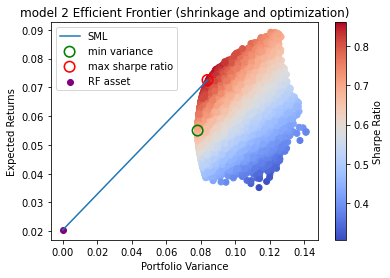

In [15]:
gen_port_shrink = {}
optimal_shrink = {}
for model in sh_covariances:
    rf = risk_free_rates[model].mean()[0]
    cov = sh_covariances[model]
    ret = expected_returns_dict[model]
    n = 52

    gen_ret, gen_var, gen_w, gen_sr = generate_portfolios(100000, cov, ret, rf)

    print(f'\n{model} (Rf: {round(rf, 4)}):')
    weights_minvar, vol_minvar, ret_minvar = minimize_var(ret, cov, rf, n, eq_weights, bound, constraint)
    weights_maxshr, vol_maxshr, ret_maxshr = maximize_sharpe(ret, cov, rf, n, eq_weights, bound, constraint)
    gen_port_shrink[model] = pd.DataFrame({'ret': gen_ret, 'vol': gen_var, 'sr': gen_sr})  # store data generated data

    optimal_shrink[model] = {'min_v': {'volatility': vol_minvar, 'return': ret_minvar, 'weights': weights_minvar},
                             'max_sr': {'volatility': vol_maxshr, 'return': ret_maxshr, 'weights': weights_maxshr}}

    plt.scatter(gen_var, gen_ret, c=gen_sr, cmap='coolwarm')
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(vol_minvar, ret_minvar, facecolors='none', edgecolors='green', s=110, linewidth=1.6,
                label='min variance')
    plt.scatter(vol_maxshr, ret_maxshr, facecolors='none', edgecolors='red', s=110, linewidth=1.6,
                label='max sharpe ratio')
    rfr = risk_free_rates[model].mean()[0]
    plt.scatter(0, rfr, c='purple', label='RF asset')  # risk free rate is far off so visualization is not proper
    plt.plot([0, vol_maxshr], [rfr, ret_maxshr], label='SML')
    plt.legend()
    plt.xlabel('Portfolio Variance')
    plt.ylabel('Expected Returns')
    plt.title(f'{model} Efficient Frontier (shrinkage and optimization)')
    plt.show()

In the upper graphs, we have plotted the same efficient frontiers, but in addition, we also plotted the security market line in order to visualize how the max sharpe ratio is the point of tangency between the portfolio and the risk free asset. As with the shrinkage we have changed the covariance matrix of the data, we need to plot again all the data points to visualize the efficient portfolio.

### Explain advantage of shrinkage in smaller samples



The appliance of shrinkage to a sample aims to reduce the overall variation. For this reason we can see that the covariances matrices values will be generally lower.
In smaller samples the shrinkage method should normalize the weights between all of the sample data, reducing the weight of some of the outliers. Usually when shrinking a smaller sample we will be driving it closer to zero, improving the mean square error. In this case, this is visible as all the values on the shrank covariance matrix are lower than the normal covariance matrix.

Shrinkage, applied to these type of time series can help to optimize further the different parameters. In this case we are estimating the optimal portfolio given the weights of 5 different assets, by minimizing the variance or maximizing the sharpe ratio. Particularly, the Ledoit-Wolf shrinkage can really help: the variance analysis of a portfolio is prone to errors in the estimation part (for example, while dealing with the expected results back in part 1 point 3), by reducing the sample error we can reduce this negative effect.

If we take a look at the model 1, we can see that for the same matrix of log returns, we obtain a portfolio with even lower variance by using the shrank covariance matrix. As for the model 2, we can notice a similar thing. For the min-variance portfolio we have an even lower variance, and also a slightly higher sharpe ratio. For the max-sharpe ratio portfolio, we again have a larger sharpe ratio, therefore maximizing the returns on variance.

Furthermore, we can take a look at the plots of the portfolios generated with the shrinkage method. The efficient frontier looks very similar, as it should, only the values defer slightly. We have obtained better results overall, both in terms of minimum variance and maximum sharpe ratio for both models in comparison to the previous optimization. In the model 2 it is clear how the security market line is tangent to the efficient frontier, but in the model 1 we have a particular case, where the optimal portfolio is on the top of the efficient frontier and the line is not tangent in the same way. In this case, we have a peak, exactly at the point where the portfolio is only conformed by the ^GSPC asset. As we have a short period of stock returns, and they are all negative, we see the form of a 'horn', and the top point or spike is tangent to every other point outside the efficient frontier.

Lastly, to visualize how the shrinkage method really affects the portfolios, we will plot the sharpe ratio versus the expected return for both conventional covariance and shrinkaged covariance matrix used:


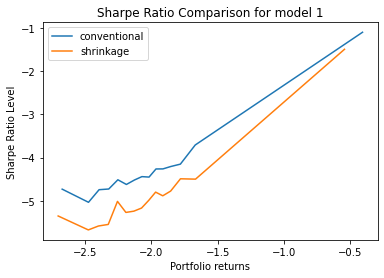

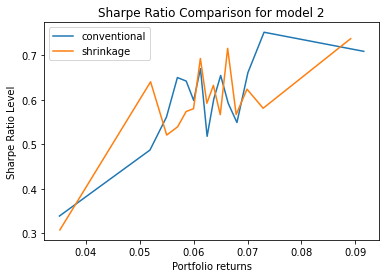

In [16]:
for model in models:
    # order portfolio returns, take index of those returns and plot sr
    n = 15
    ordered_pf = gen_port[model].sort_values('ret')
    indexes = np.linspace(0, len(ordered_pf) - 1, n, dtype=int)
    plt.plot(ordered_pf.iloc[indexes].ret, ordered_pf.iloc[indexes].sr, label="conventional")

    ordered_pf = gen_port_shrink[model].sort_values('ret')
    indexes = np.linspace(0, len(ordered_pf) - 1, n, dtype=int)
    plt.plot(ordered_pf.iloc[indexes].ret, ordered_pf.iloc[indexes].sr, label="shrinkage")
    plt.xlabel("Portfolio returns")
    plt.ylabel("Sharpe Ratio Level")
    plt.title(f'Sharpe Ratio Comparison for {model}')
    plt.legend()
    plt.show()


In the upper graphs we see how the expected returns compare to the sharpe ratio in the different portfolios. In the first graph, representing the smaller sample in model 1, we see clearly how the sharpe ratio is level is lower, confirming previous statements about the effect of shrinkage in smaller samples.

All in all, with the Ledoit-Wolf shrinkage method we can truly optimize the algorithms, and obtain better fitted results.


### Final Portfolio

In [17]:
print('Final portfolio weights:')
print(pd.Series(np.around(optimal_shrink['model 2']['max_sr']['weights'] * 100, 3), ticker_list))
print(f'sum of weights: {sum(optimal_shrink["model 2"]["max_sr"]["weights"])}')
# print(pd.Series(np.around(weights_maxshr*100,3),ticker_list) > expected_returns_dict['model 2'])
print(
    f'The returns of the portfolio are better than the annualised returns individually: {not False in (optimal_shrink["model 2"]["max_sr"]["return"] > expected_returns_dict["model 2"])}')

Final portfolio weights:
^DJI      0.000
^GSPC    41.754
^FTSE    39.872
EZU       0.000
GLD      18.374
dtype: float64
sum of weights: 1.0
The returns of the portfolio are better than the annualised returns individually: True


Between both models it is clear that we should use the second one, as stated previously. Between the normal covariance matrix, and the shrank, we will be using the portfolio weights outputted by the shrinkage method. The results obtained in comparison are a lower variance, for the same expected returns. This also gives us a higher sharpe ratio, while maintaining a variance similar or almost identical to the min-variance portfolio.
Therefore, the weights obtained for this portfolio are only 3 assets:

 - `^GSPC`: 41.754 %
 - `^FTSE`: 39.872 %
 - `GLD`: 18.374 %

With these weights, we would have an expected return of 7.25 % with a volatility of 8.39 %, which outperform each one of the stocks individually during the selected timeframe.